## Environment Set-up

In [1]:
# for CPU dataframe manipulation
import pandas as pd
import numpy as np

# for GPU dataframe manipulation (only execute the above cuda thing when GPU models needed)
# import cudf,cupy

# for ploting 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import math
import gc
import pprint

# remove warnings 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# file path
import os 

# Deep Learning
# import tensorflow as tf
# import tensorflow.keras.backend as K
# print('Using TensorFlow version',tf.__version__)


print('✔️ Libraries Imported!')

✔️ Libraries Imported!


# Exploratory Data Analysis 
We start by reading the labels for the training data. There are neither missing values nor duplicated customer_IDs. Of the 458913 customer_IDs, 340000 (74 %) have a label of 0 (good customer, no default) and 119000 (26 %) have a label of 1 (bad customer, default). <br>

We know that the good customers have already been *subsampled* by a factor of 20; this means that in reality there are 6.8 million good customers. 98 % of the customers are good; 2 % are bad. <br>

__*Analysis*__ <br>

The classes are imbalanced, therefore we would use a  StratifiedKFold for cross-validation. <br>

At the same time, because the classes are imbalanced, accuracy would be a bad metric to evaluate a classifier. I'll use __*AUC*__ and __**Recall**__ for the evalueation metrix for this classification problem. 

In [2]:
# merge the label with the training data
train = pd.read_parquet('C:\\Users\\hs324\\OneDrive\\Desktop\\Private\\08_SomeNewCode\\08_IndepentProject\\default_prediction_in_large_scale\\data\\train.parquet')
labels = pd.read_csv('C:\\Users\\hs324\\OneDrive\\Desktop\\Private\\08_SomeNewCode\\08_IndepentProject\\default_prediction_in_large_scale\\data\\train_labels.csv')
train_raw = train.merge(labels, left_on='customer_ID', right_on='customer_ID')

In [3]:
train_raw.shape

(5531451, 191)

In [4]:
# change data types for certain columns in categorical type 
train_raw['S_2'] = pd.to_datetime(train_raw['S_2'])
categorical_features = ['B_30', 'B_38', 'D_63', 'D_64', 'D_66', 'D_68', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126']
train_raw[categorical_features] = train_raw[categorical_features].astype("category")
train_raw[categorical_features].dtypes

B_30     category
B_38     category
D_63     category
D_64     category
D_66     category
D_68     category
D_114    category
D_116    category
D_117    category
D_120    category
D_126    category
dtype: object

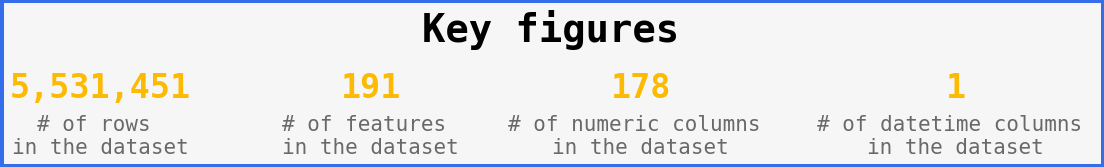

In [5]:
# visualize the key key figures 
mpl.rcParams.update(mpl.rcParamsDefault)

data = train_raw
df_dtypes = train_raw.dtypes.value_counts()

fig = plt.figure(figsize=(5,2),facecolor='white')

ax = fig.add_subplot(1,1,1)
font = 'monospace'
ax.text(1, 0.8, "Key figures",color='black',fontsize=28, fontweight='bold', fontfamily=font, ha='center')

ax.text(0, 0.4, "{:,d}".format(data.shape[0]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax.text(0, 0.001, "# of rows \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily=font,ha='center')

ax.text(0.6, 0.4, "{}".format(data.shape[1]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax.text(0.6, 0.001, "# of features \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily=font,ha='center')

ax.text(1.2, 0.4, "{}".format(len(data.select_dtypes(np.number).columns)), color='#fcba03', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax.text(1.2, 0.001, "# of numeric columns \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily=font, ha='center')

ax.text(1.9, 0.4,"{}".format(len(data.select_dtypes('datetime').columns)), color='#fcba03', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax.text(1.9, 0.001,"# of datetime columns \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily=font,ha='center')

ax.set_yticklabels('')
ax.tick_params(axis='y',length=0)
ax.tick_params(axis='x',length=0)
ax.set_xticklabels('')

for direction in ['top','right','left','bottom']:
    ax.spines[direction].set_visible(False)

fig.subplots_adjust(top=0.9, bottom=0.2, left=0, hspace=1)

fig.patch.set_linewidth(5)
fig.patch.set_edgecolor('#346eeb')
fig.patch.set_facecolor('#f6f6f6')
ax.set_facecolor('#f6f6f6')
    
plt.show()

### 3.1 Missing Data 

In [6]:
# check the time range of the available data
print(f'Train dates range is from {train_raw["S_2"].min()} to {train_raw["S_2"].max()}.')

Train dates range is from 2017-03-01 00:00:00 to 2018-03-31 00:00:00.


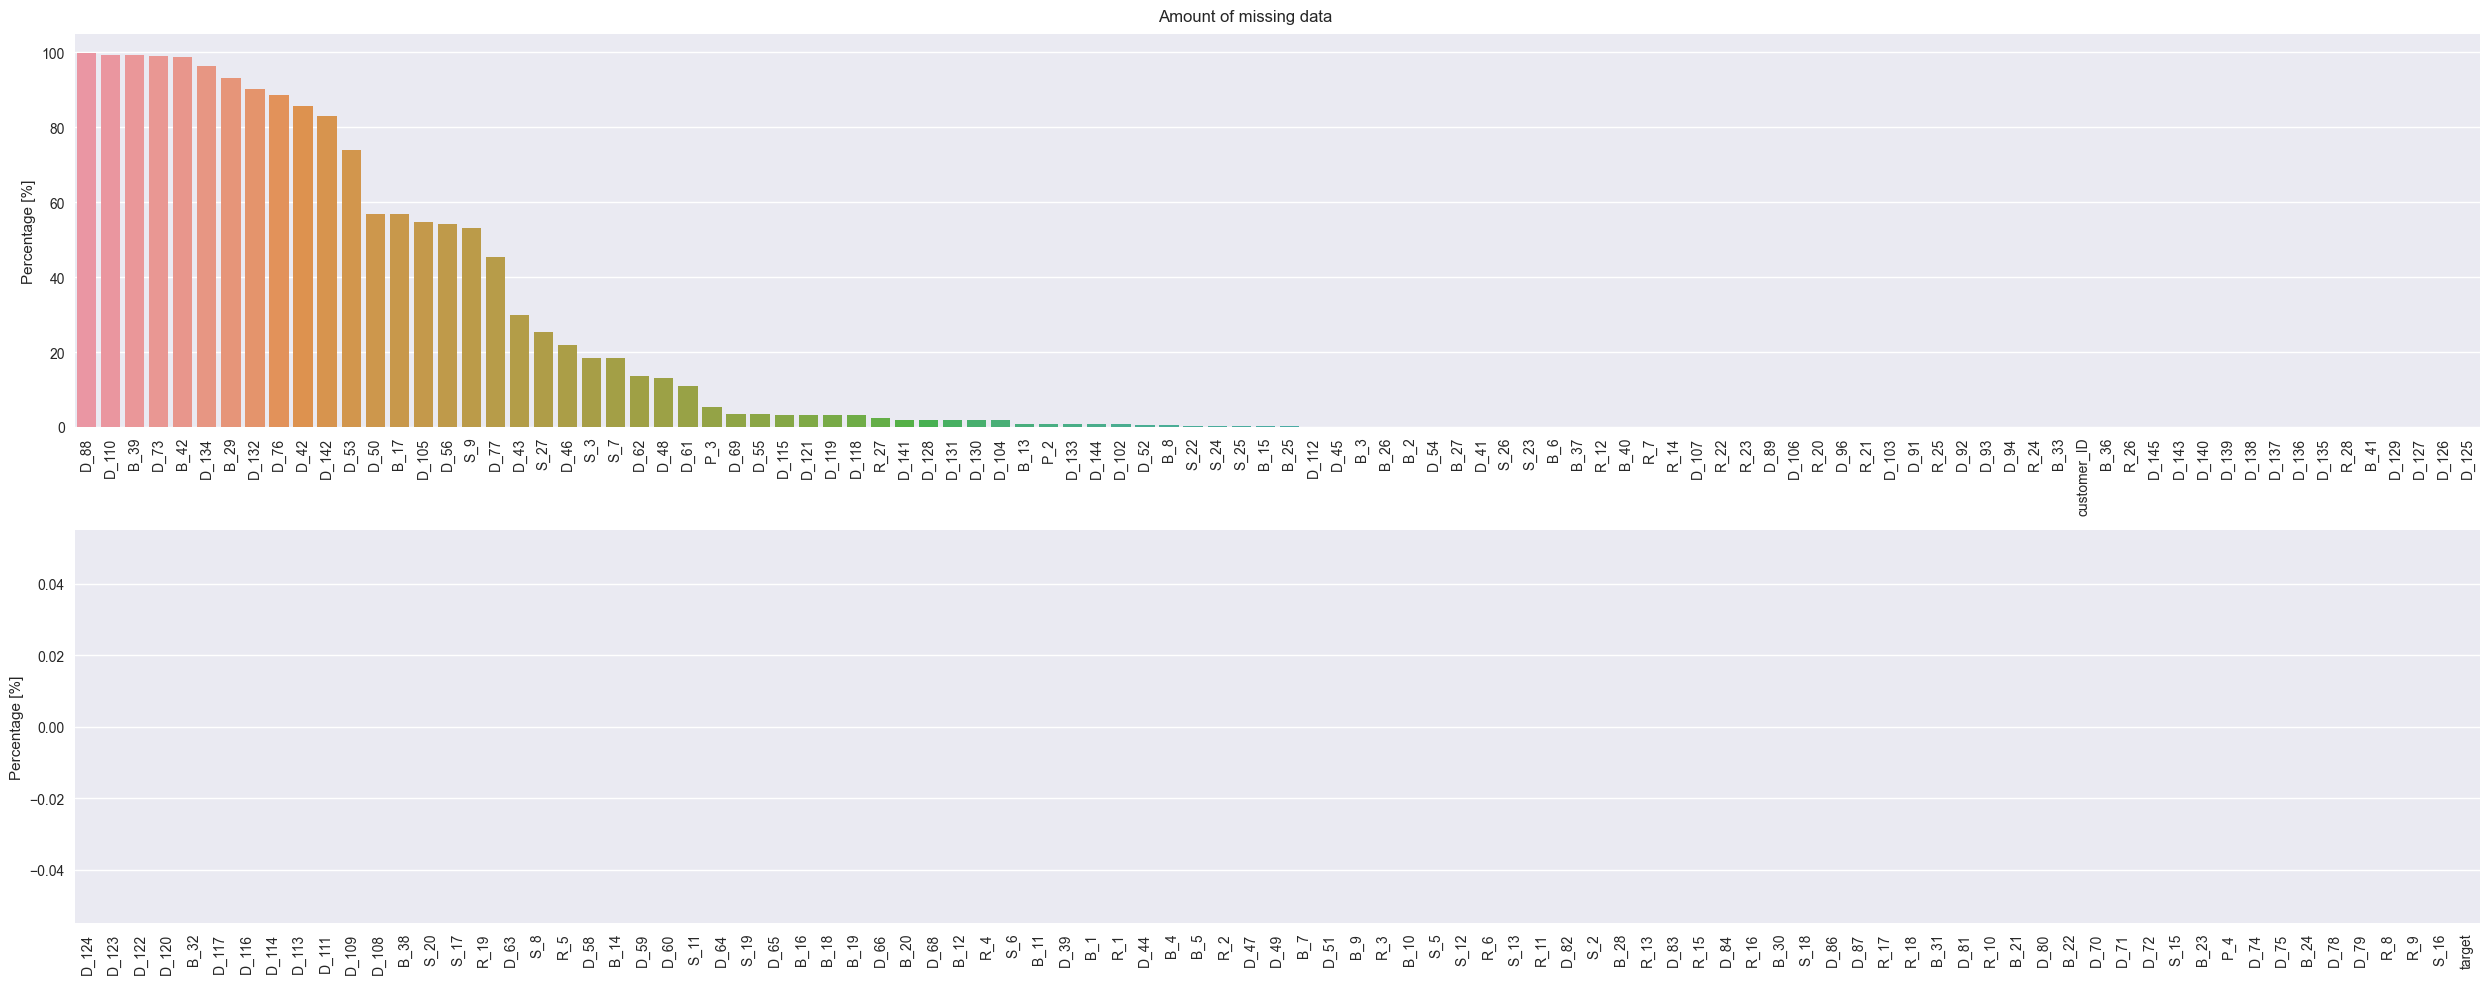

In [7]:
# plot the percentage of data missing for each variable
tmp = train_raw.isna().sum().div(len(train_raw)).mul(100).sort_values(ascending=False)

plt.style.use('seaborn')
fig, ax = plt.subplots(2,1, figsize=(25,10))
sns.barplot(x=tmp[:100].index, y=tmp[:100].values, ax=ax[0])
sns.barplot(x=tmp[100:].index, y=tmp[100:].values, ax=ax[1])
ax[0].set_ylabel("Percentage [%]"), ax[1].set_ylabel("Percentage [%]")
ax[0].tick_params(axis='x', rotation=90); ax[1].tick_params(axis='x', rotation=90)
plt.suptitle("Amount of missing data")
plt.tight_layout()
plt.show()


There is a significant number of features with a lot of missing data.

### 3.2 Distribution of a target variable 

In [8]:
tmp = train_raw['target'].value_counts().div(len(train_raw)).mul(100)
tmp

0    75.090279
1    24.909721
Name: target, dtype: float64

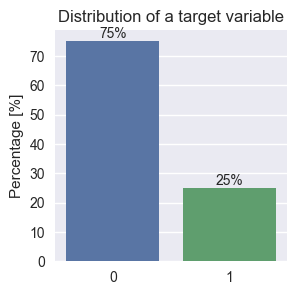

In [9]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(3, 3))

sns.barplot(x=tmp.index, y=tmp.values, ax = ax)
ax.bar_label(ax.containers[0], fmt='%.f%%')
plt.title("Distribution of a target variable")
plt.ylabel("Percentage [%]")
plt.show()

It's clear that our dataset is unbalanced and this is a crucial point to keep in mind while modelling. 25% of customers had a default - it will be worth investigating these two groups separately to find some differences. First let's see how many unique customers do we have.

In [10]:
print(f'Number of unique customers: {train_raw["customer_ID"].nunique()}')

Number of unique customers: 458913


### 3.3 Customer Presence

In [11]:
# see how long have each customer stayed in the statement
cust_presence = train_raw.groupby(['customer_ID','target']).size().reset_index().rename(columns={ 0 : 'presence'})
cust_presence.head()

,customer_ID,target,presence
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,13
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0,13
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0,13
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0,13
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0,13


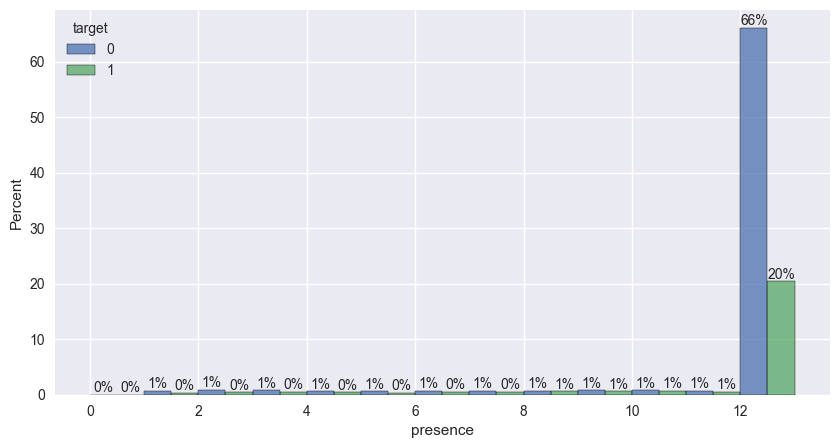

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.histplot(x='presence', data=cust_presence, hue='target', stat='percent', multiple="dodge", bins=np.arange(0,14), ax=ax)
ax.bar_label(ax.containers[0], fmt='%.f%%')
ax.bar_label(ax.containers[1], fmt='%.f%%')
plt.show()

**_Analysis_**:<br>
The histplot shows that (66% + 20% + 1% + 1%)= 88% of the customers have the retention more than one year, yet it's difficult to see clearly for the remaining customers, so I'll zoom in and have a closer look.

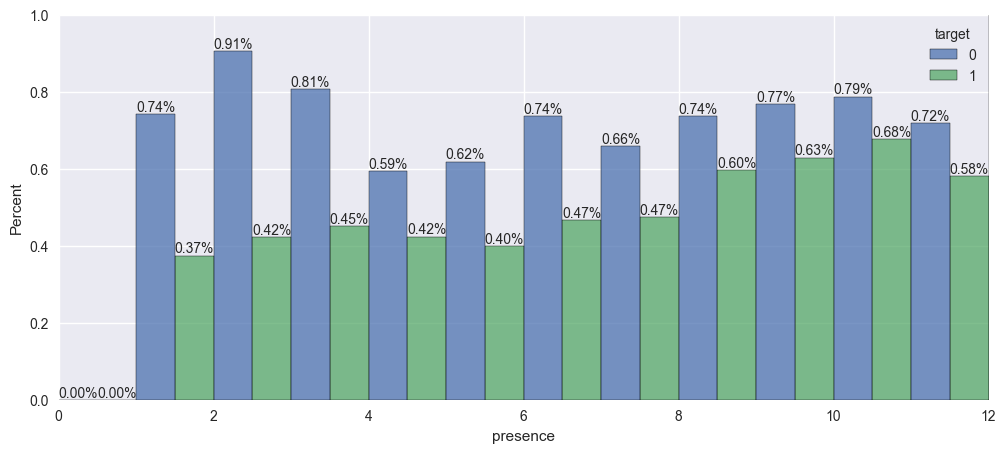

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.histplot(x='presence', data=cust_presence, hue='target', stat='percent', multiple="dodge", bins=np.arange(0,14), ax=ax)
ax.bar_label(ax.containers[0], fmt='%.2f%%')
ax.bar_label(ax.containers[1], fmt='%.2f%%')
# set constrains for only one month 
ax.set_xlim(0,12)
ax.set_ylim(0,1)
plt.show()

**_Analysis_**:<br>
It's now much more clearer as we look closer at the customers with less than 12 statements, that people who have a less than one year of experience are more tends to churn. 

### 3.4 Correlations

Before we dive in into distributions of the individual features let's check are there any highly correlated ones. Because it would take ages to calculate the entire correlation matrix I'll use an approximate method by using a sample of 25% of customers.

In [15]:
def sample_full_cust(df, cust_ratio):
    """
    function for randomly select certain portion of ids
    -----------------------------------------------
    df: the original dataframe
    cust_ratio: percentage of the number that be shown
    
    """
    n_customers = df['customer_ID'].nunique()
    no_of_cust = int(n_customers*cust_ratio)
    cust_ids = np.random.choice(df['customer_ID'].unique(), no_of_cust)
    print(f'Number of customers sampled: {no_of_cust}')
    ready_df = df[df['customer_ID'].isin(cust_ids)]
    print(f'Number of rows sampled: {len(ready_df)} ({round(len(ready_df)/len(df)*100)}%)')
    return ready_df


In [16]:
train_samples = sample_full_cust(train_raw, 0.25)

Number of customers sampled: 114728
Number of rows sampled: 1224079 (22%)


In [17]:
# calculate the correlations 
correlations = train_samples.corr().abs()

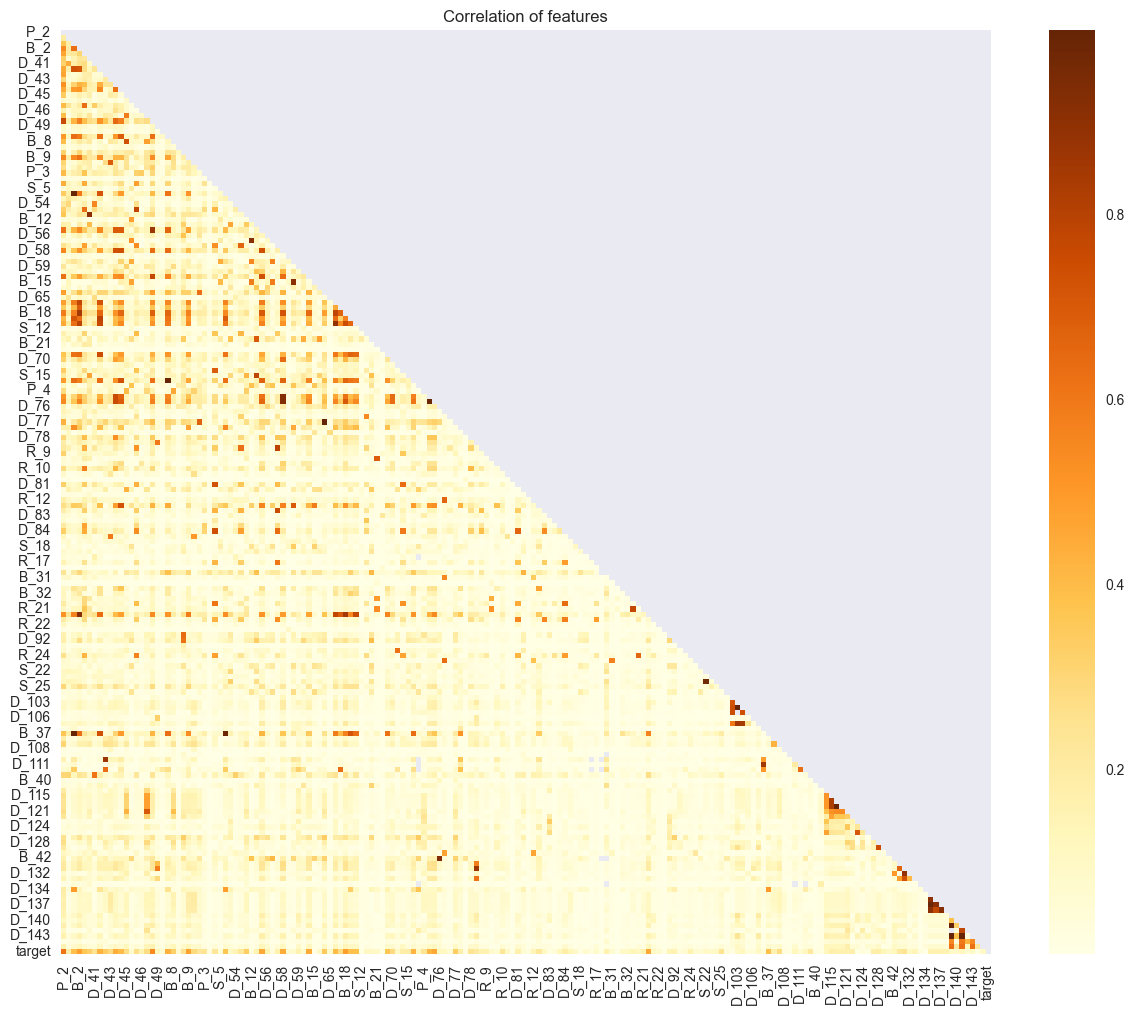

In [18]:
# get the upper triangle of an array
mask=np.triu(np.ones_like(correlations))

# corr using heatmap 
fig, ax = plt.subplots(1,1, figsize=(15,12))
sns.heatmap(correlations, ax=ax, mask=mask, cmap='YlOrBr')
ax.set_title("Correlation of features")
plt.show()

The above heatmap includes all the columns that we cannot directly derive any useful information from it, therefore I am about to zoom in the columns in different variable categories, and see if I can gain more insights upon it. 

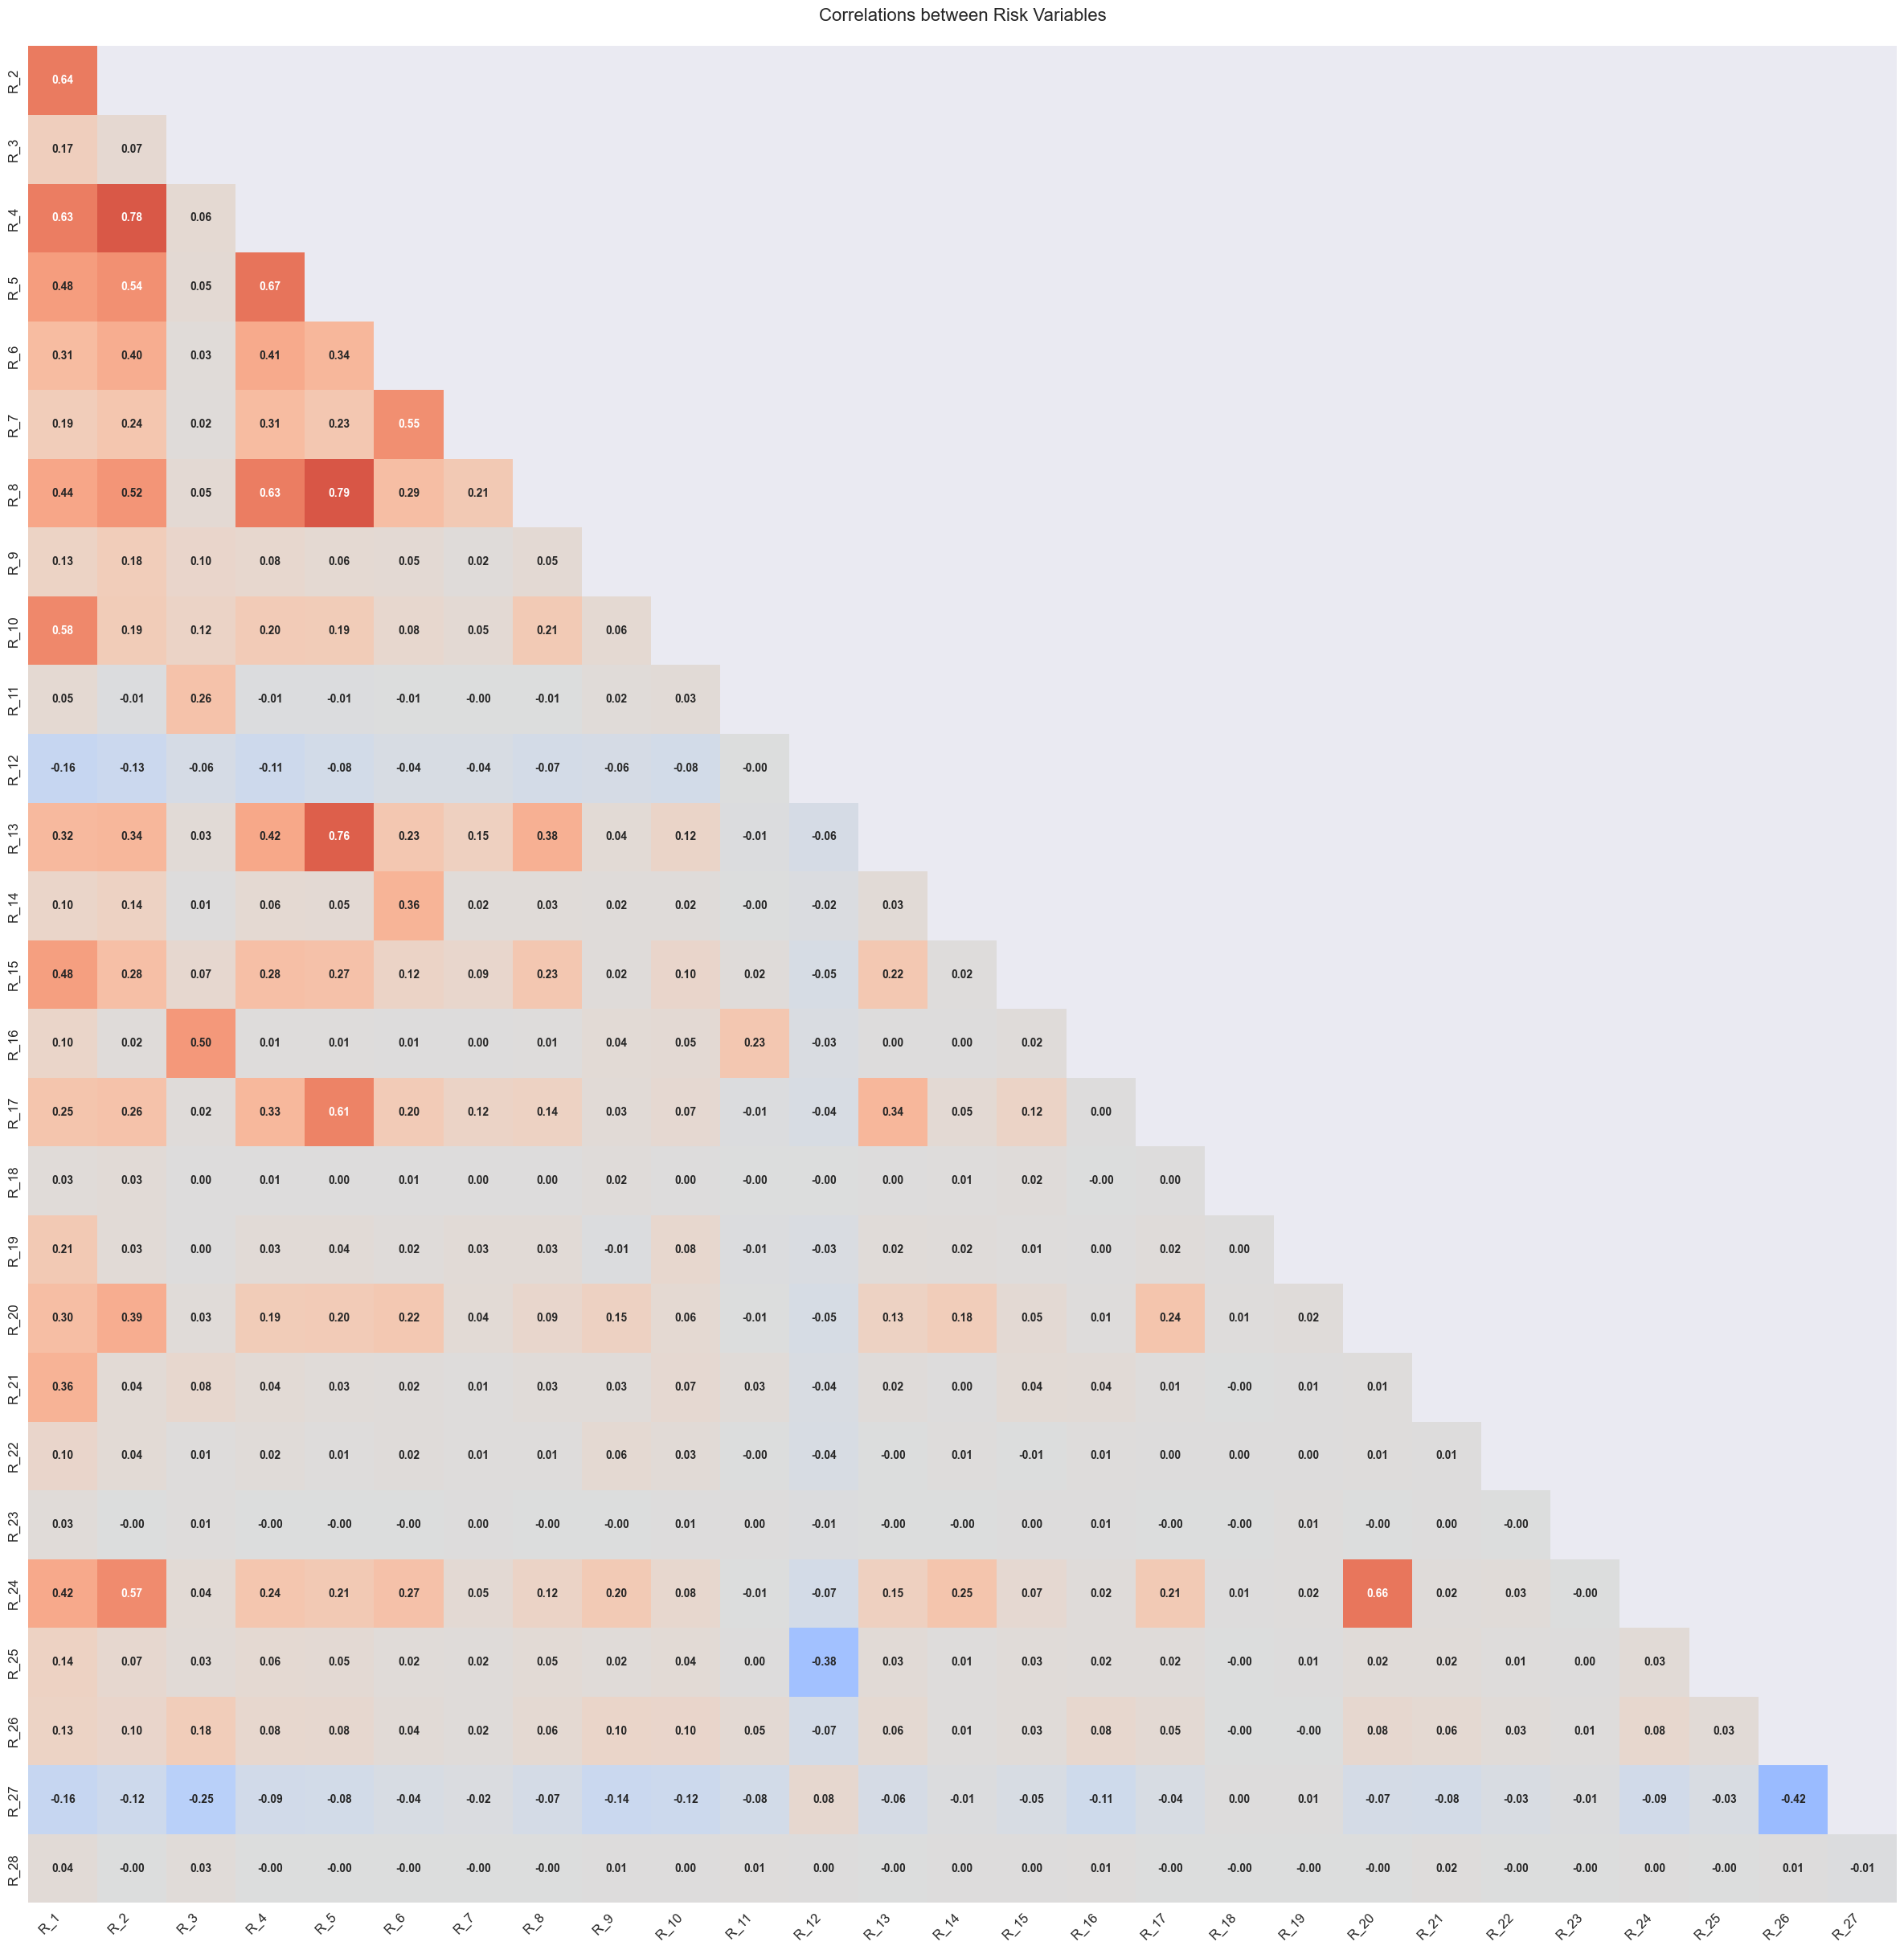

In [37]:
# zoom in for Risk variables
cols_to_show = [c for c in train_samples.columns if (c.startswith('R'))]
corr = train_samples[cols_to_show].corr()
mask = np.triu(np.ones_like(corr))[1:, :-1]
corr = corr.iloc[1:, :-1].copy()

# draw the heap map using the mask 
fig, ax = plt.subplots(figsize = (30,30))
sns.heatmap(corr, mask = mask, 
            vmin = -1, vmax = 1, center = 0,
            annot = True, fmt= '.2f', 
            cmap = 'coolwarm', cbar=False,
            annot_kws={'fontsize':10,'fontweight':'bold'})
ax.tick_params(left = False, bottom = False)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, 
                   horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 12)
plt.title('Correlations between Risk Variables\n', fontsize = 16)
plt.show()


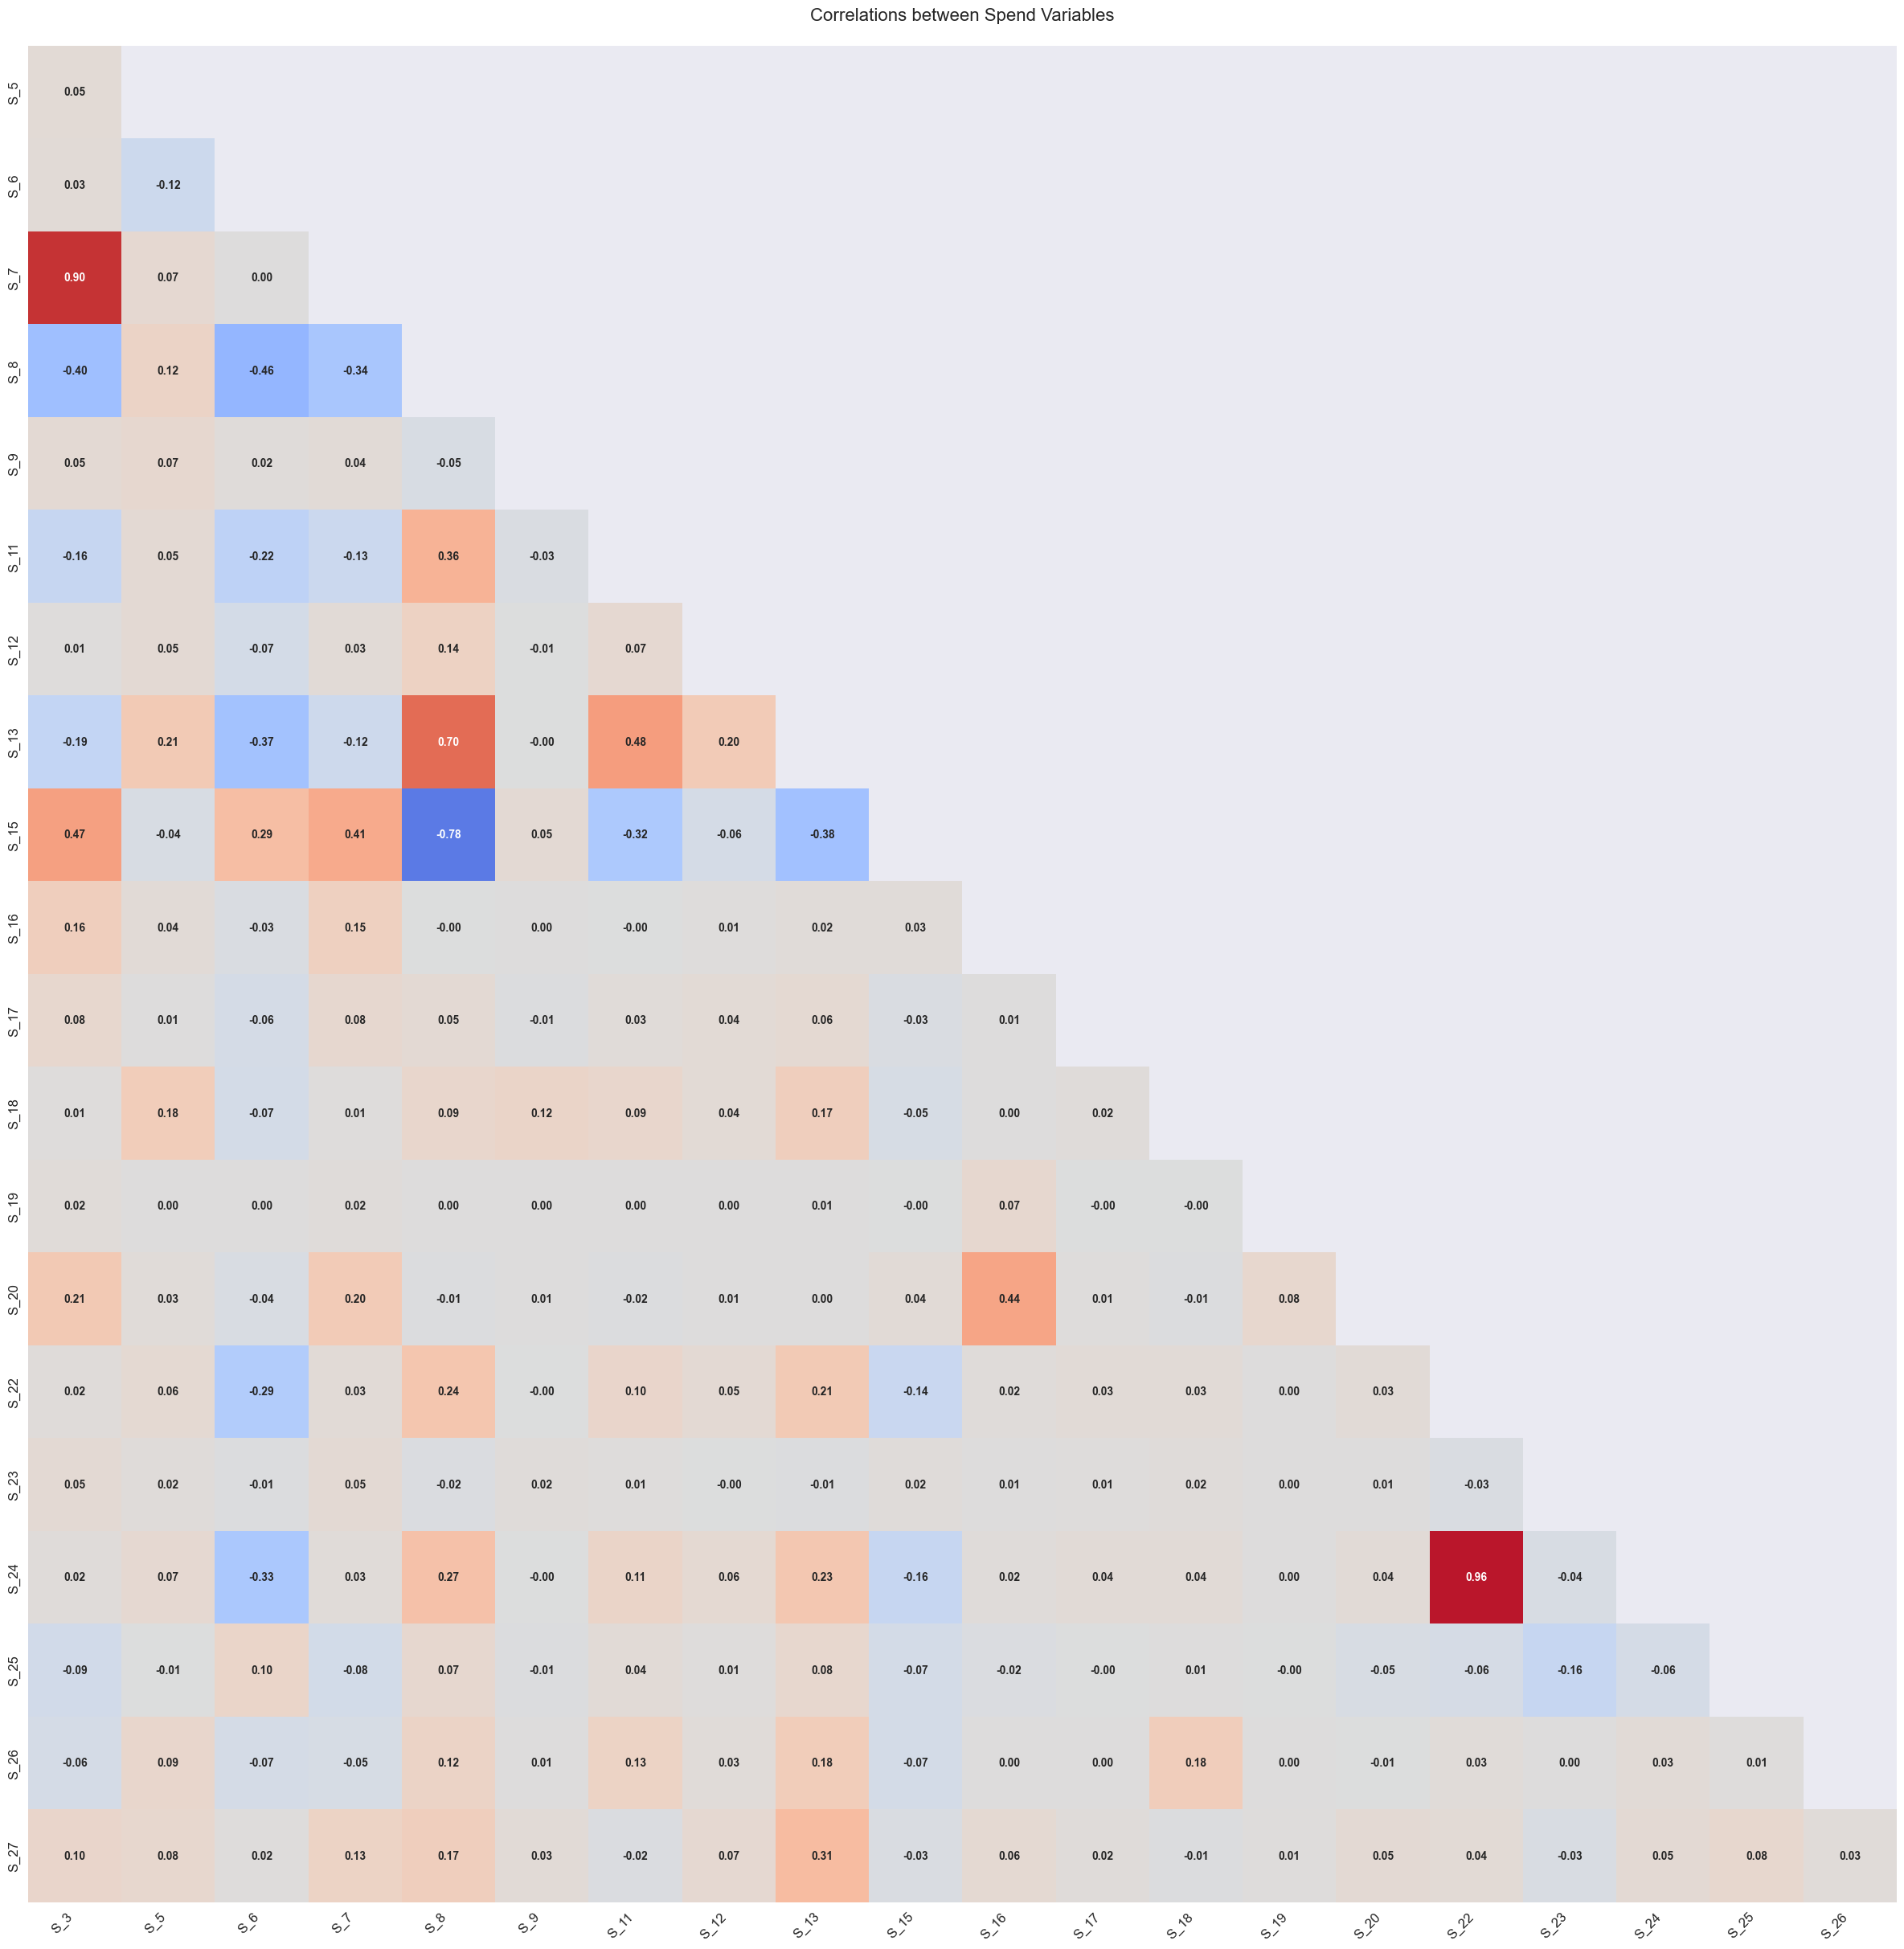

In [38]:
# zoom in for Spend variables
cols_to_show = [c for c in train_samples.columns if (c.startswith('S'))]
corr = train_samples[cols_to_show].corr()
mask = np.triu(np.ones_like(corr))[1:, :-1]
corr = corr.iloc[1:, :-1].copy()

# draw the heap map using the mask 
fig, ax = plt.subplots(figsize = (30,30))
sns.heatmap(corr, mask = mask, 
            vmin = -1, vmax = 1, center = 0,
            annot = True, fmt= '.2f', 
            cmap = 'coolwarm', cbar=False,
            annot_kws={'fontsize':10,'fontweight':'bold'})
ax.tick_params(left = False, bottom = False)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, 
                   horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 12)
plt.title('Correlations between Spend Variables\n', fontsize = 16)
plt.show()


**_Analysis_**:<br>
The heatmap above shows us that most of features is not correlated but there are visible dark 'pixels' meaning we have some highly-correlated ones. In order to print them from the most correlated to the least we have to unstack the results.

In [19]:
# pivot a level of the (necessarily hierarchical) index labels. 
unstacked = correlations.unstack()
unstacked = unstacked.sort_values(ascending=False, kind="quicksort").drop_duplicates().head(25)
unstacked

P_2    P_2      1.000000
D_62   D_77     0.999788
D_104  D_103    0.999782
D_139  D_143    0.999667
D_141  D_139    0.998224
D_143  D_141    0.997799
B_1    B_11     0.995745
B_7    B_23     0.995008
D_119  D_118    0.994777
B_37   B_1      0.992567
       B_11     0.987769
D_75   D_74     0.987694
D_135  D_137    0.983528
S_22   S_24     0.962748
D_76   B_42     0.930403
D_75   D_58     0.925882
D_58   D_74     0.922565
D_137  D_138    0.919666
B_33   B_2      0.912473
B_13   B_12     0.911310
D_135  D_138    0.909297
B_14   B_15     0.908233
D_136  D_137    0.906731
S_3    S_7      0.904823
D_136  D_135    0.902652
dtype: float64

**_Analysis_**:<br>
From this we can see that we do have lots of highly correlated features, I'll plot the correlated feature to visualize them first.  

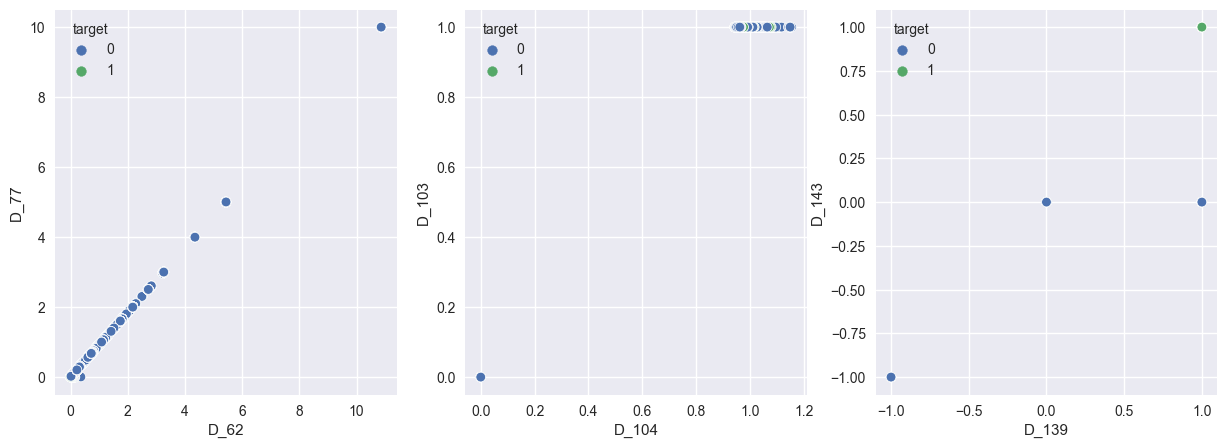

In [25]:
# randomly select few feature to do the exploration 
x1, y1 = unstacked.index[1]
x2, y2 = unstacked.index[2]
x3, y3 = unstacked.index[3]

# get the corresponding data from the train sets 
fig, ax = plt.subplots(1, 3, figsize = (15,5))
sns.scatterplot(x = x1, y = y1, data = train_samples, hue = 'target', ax = ax [0])
sns.scatterplot(x=x2, y=y2, data=train_samples, hue='target', ax=ax[1])
sns.scatterplot(x=x3, y=y3, data=train_samples, hue='target', ax=ax[2])
plt.show()

### 3.4 Categorical features

There's a list of the categorical features that was provided, and here I would have a deeper look at those. 

In [40]:
# randomly choose 10 line to show 
train_raw[categorical_features].sample(10)

,B_30,B_38,D_63,D_64,D_66,D_68,D_114,D_116,D_117,D_120,D_126
3000023,0,3,3,2,-1,1,1,0,4,0,2
3968209,0,1,3,2,-1,6,1,0,0,0,2
3852232,0,1,3,0,-1,6,1,0,5,0,2
3511092,0,2,4,0,-1,6,1,0,4,0,2
3719630,0,2,3,0,-1,6,1,0,0,0,2
3758827,0,5,3,0,-1,6,1,0,5,1,2
1271867,0,3,3,0,-1,6,1,0,5,0,2
3609324,0,3,0,0,-1,6,1,0,0,0,2
1683646,2,3,3,0,-1,4,1,0,5,0,2
4268245,0,2,3,3,-1,6,1,0,0,0,2


In [48]:
# check the unique values per categorical column
for cf in categorical_features: 
    print(cf, list(train_raw[cf].unique())) # note: DataFrames do not have that method; columns in DataFrames do

B_30 [0, 2, 1, -1]
B_38 [2, 1, 3, 5, 6, 7, 4, -1]
D_63 [0, 3, 4, 1, 2, 5]
D_64 [0, 2, -1, 3, 1]
D_66 [-1, 1, 0]
D_68 [6, 2, 3, -1, 5, 4, 0, 1]
D_114 [1, 0, -1]
D_116 [0, -1, 1]
D_117 [5, 0, 7, 3, 2, -1, 4, 6]
D_120 [0, 1, -1]
D_126 [2, -1, 1, 0]


In [51]:
# check the missing values per categorical variable
train_raw[categorical_features].isna().sum().sort_values(ascending=False)

B_30     0
B_38     0
D_63     0
D_64     0
D_66     0
D_68     0
D_114    0
D_116    0
D_117    0
D_120    0
D_126    0
dtype: int64

In [56]:
def show_kdeplots(letter, figsize):
    cols = [c for c in train_samples.columns if (
        (c.startswith((letter,'t'))) & (c not in categorical_features)
    )]
    df_tmp = train_samples[cols]
    plt_cols = 5
    plt_rows = math.ceil(len(cols)/plt_cols)

    fig, axes = plt.subplots(plt_rows, plt_cols, figsize = figsize)
    for i, ax in enumerate(axes.reshape(-1)):
        if i < len(cols) -1: 
            sns.kdeplot(x = cols[i], hue = 'target', hue_order= [1,0],
                        label=['Default','Paid'], data = df_tmp,
                        fill=True, linewidth=2, legend=False, ax=ax)
        ax.tick_params(left=False, bottom=False, labelsize=5)
        ax.xaxis.get_label().set_fontsize(10)
        ax.set_ylabel('')

    sns.despine(bottom=True, trim=True)
    plt.tight_layout(rect=[0, 0.2, 1, 0.99])
    plt.show()


In [ ]:
# takes forever to run for some reasons 
show_kdeplots('D', (15,30))